<a href="https://colab.research.google.com/github/Dharani578/FMML_COURSE/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-07 13:45:44--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.172.170.53, 18.172.170.8, 18.172.170.43, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.172.170.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   235MB/s    in 0.2s    

2024-05-07 13:45:44 (235 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


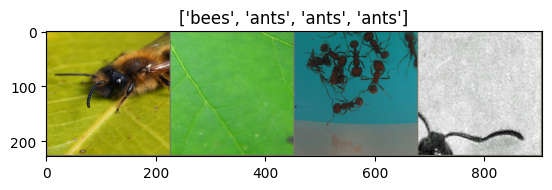

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.8MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6185 Acc: 0.7049

Epoch 1/4
----------
Loss: 0.4884 Acc: 0.8156

Epoch 2/4
----------
Loss: 0.6694 Acc: 0.7541

Epoch 3/4
----------
Loss: 0.5363 Acc: 0.8033

Epoch 4/4
----------
Loss: 0.3424 Acc: 0.8648



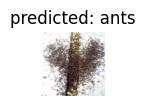

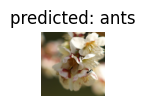

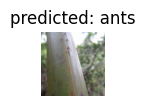

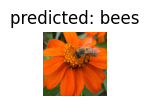

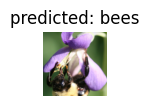

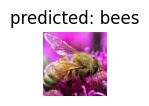

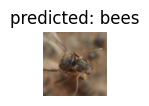

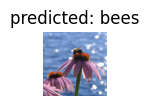

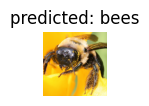

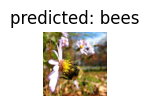

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


1 ANS

Increased Robustness: Augmentations help create a more robust model by exposing it to variations in the training data. By presenting the model with slightly altered versions of the same image, it learns to generalize better and becomes more tolerant to changes in the input during inference.
Improved Generalization: By augmenting the training data, the model learns to recognize objects under different conditions, such as varying lighting conditions, orientations, and scales. This helps prevent overfitting and improves the model's ability to generalize to unseen data.
Data Efficiency: Augmentations allow you to effectively increase the size of your training dataset without collecting additional labeled data. This is particularly beneficial when labeled data is scarce or expensive to obtain.
Regularization: Augmentations act as a form of regularization by adding noise or variations to the training data, which can help prevent the model from memorizing the training examples and instead encourages it to learn more robust features.
Addressing Data Imbalance: In datasets where certain classes are underrepresented, augmentations can be used to generate synthetic examples of the minority classes, helping to balance the dataset and improve the model's performance on those classes.
Domain Adaptation: In applications where the distribution of the training and test data may differ (e.g., images taken in different lighting conditions), augmentations can help the model adapt to the target domain by simulating variations present in the test data.
Overall, data augmentations are a powerful tool for improving the performance, robustness, and generalization ability of machine learning models, particularly in scenarios where labeled data is limited or when the training and test data may differ in distribution.








2 ANS

If you don't use a pre-trained ResNet model and train the model from scratch on your dataset, the performance may vary depending on factors such as the size and diversity of your dataset, the complexity of the task, and the hyperparameters chosen for training.

Training a deep neural network like ResNet from scratch typically requires a large amount of labeled data and computational resources. Without pre-training on a large dataset like ImageNet, the model starts with randomly initialized weights, which means it needs to learn meaningful representations of the data entirely from scratch during training.

In many cases, training a deep neural network without pre-training may lead to slower convergence and inferior performance compared to using pre-trained weights. Pre-training allows the model to start with features that have already been learned on a large dataset, which can significantly speed up convergence and improve generalization performance, especially when the target dataset is small or similar to the pre-training dataset.

However, if you have a sufficiently large and diverse dataset and are willing to invest the computational resources and time required for training from scratch, it's still possible to achieve good performance without pre-training. The key is to carefully tune the model architecture, learning rate, regularization techniques, and other hyperparameters to ensure effective training.

In summary, while training a ResNet model from scratch without pre-training is feasible, it may require more effort and computational resources to achieve competitive performance compared to using pre-trained weights.








3 ANS

Transfer Learning Benefits: Pre-trained models, even if trained on a different dataset, have learned to extract general features that are useful for various computer vision tasks. These features include edge detectors, texture detectors, and more complex patterns. So, even if the pre-training dataset is different, the initial layers of the pre-trained model can still capture low-level features that are relevant to the new task.
Domain Differences: However, if the pre-training dataset is significantly different from the target dataset (such as ImageNet vs. ants vs. bees), there may be domain-specific features that the pre-trained model did not learn, and these features might be crucial for the new task. In such cases, fine-tuning the pre-trained model on the target dataset or re-training only the last few layers (while keeping the early layers fixed) can help adapt the model to the new domain.
Data Efficiency: Even if the pre-trained model's features are not perfectly aligned with the target domain, using pre-trained weights can still provide a good starting point for training on the new dataset. This can lead to faster convergence and require less labeled data compared to training from scratch.
Performance Trade-offs: The extent to which the pre-trained model's features generalize to the new task depends on the similarity between the pre-training and target datasets. If the datasets are too dissimilar, using a pre-trained model might not provide significant benefits, and it may be more effective to train from scratch or fine-tune on a more closely related pre-training dataset.
In summary, while using a pre-trained ResNet model on a significantly different dataset may still offer benefits such as transfer learning and data efficiency, the extent of its performance on the new task depends on the domain similarity between the pre-training and target datasets. Fine-tuning or re-training parts of the model on the target dataset can help adapt the pre-trained model to the new task and improve performance.







